In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import statistics

In [2]:
# Load in data
da = xr.open_dataset('/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/era5_day_ua250_1981-2010.nc')

0
1
2
3
5


In [3]:
# Select years 1990-2010
da = da.sel(time=slice('1990-01-01', '2010-12-31'))

In [4]:
# Calculate monthly climatologies
mon_clim = da.groupby('time.month').mean('time')

In [5]:
mon_clim = mon_clim.u

In [6]:
# Store monthly clim as variables
jan_clim = mon_clim[0]
feb_clim = mon_clim[1]
mar_clim = mon_clim[2]
apr_clim = mon_clim[3]
nov_clim = mon_clim[4]
dec_clim = mon_clim[5]

In [7]:
# Group daily data by month
jan_day = da.groupby('time.month')[1]
feb_day = da.groupby('time.month')[2]
mar_day = da.groupby('time.month')[3]
apr_day = da.groupby('time.month')[4]
nov_day = da.groupby('time.month')[11]
dec_day = da.groupby('time.month')[12]

In [8]:
# Remove monthly climatologies
jan_anom = jan_day.u - jan_clim
feb_anom = feb_day.u - feb_clim
mar_anom = mar_day.u - mar_clim
apr_anom = apr_day.u - apr_clim
nov_anom = nov_day.u - nov_clim
dec_anom = dec_day.u - dec_clim

In [9]:
# Merge dataarrays into one
# dim='time' keeps dates in order
ua_anom = xr.concat([jan_anom,feb_anom,mar_anom,apr_anom,nov_anom,dec_anom],dim='time')

In [10]:
ua_anom.time

<xarray.DataArray 'time' (time: 3806)>
array(['1990-01-01T11:30:00.000000000', '1990-01-02T11:30:00.000000000',
       '1990-01-03T11:30:00.000000000', ..., '2010-12-29T11:30:00.000000000',
       '2010-12-30T11:30:00.000000000', '2010-12-31T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T11:30:00 ... 2010-12-31T11:30:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [11]:
ua_anom = ua_anom.sortby('time',ascending=True)

In [12]:
ua_anom.shape

(3806, 401, 681)

In [13]:
# Get variables
lat = ua_anom.lat.values
lon = ua_anom.lon.values
ua = ua_anom.values

In [14]:
# Weight grid cells by cosine of latitude
latitude = np.linspace(lat.min(), lat.max(), len(lat))
weights_array = np.cos(np.deg2rad(latitude))[:, np.newaxis]

ua=ua*weights_array

In [15]:
# Reshape data into time-space format
data = np.reshape(ua, (ua.shape[0], 401*681), order = 'F')

# Write KNN algorithm by hand

In [16]:
# Apply labels for disturbance types
labels = np.load('../np_arrays/disturbance_labels.npy')

In [17]:
# Apply labels for each disturbance type
labels[np.where(labels == 4)] = 4 #KL
labels[np.where(labels == 3)] = 3 #UL
labels[np.where(labels == 2)] = 2 #CR
labels[np.where(labels == 1)] = 0 #ND
labels[np.where(labels == -1)] = 1 #NC

In [18]:
labels

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [19]:
# Load in composites for each disturbance type - these are the "truth"
path = '/network/rit/lab/elisontimmlab_rit/kf835882/python/ERA5/hourly/'

ND_truth = np.load(path+'win_map_labels_ND_truth.npy')
UL_truth = np.load(path+'win_map_0_0_labels_UL_truth.npy')
CR_truth = np.load(path+'win_map_0_0_labels_CR_truth.npy')
NC_truth = np.load(path+'win_map_2_2_labels_NC_truth.npy')
KL_truth = np.load(path+'win_map_0_2_labels_10450.npy')

In [20]:
# Reshape into 1D arrays
ND_truth = np.reshape(ND_truth, (401*681), order = 'F')
NC_truth = np.reshape(NC_truth, (401*681), order = 'F')
CR_truth = np.reshape(CR_truth, (401*681), order = 'F')
UL_truth = np.reshape(UL_truth, (401*681), order = 'F')
KL_truth = np.reshape(KL_truth, (401*681), order = 'F')

In [21]:
# Create array for neighbors
X = np.zeros(shape=[5,401*681])

In [22]:
X[0] = ND_truth
X[1] = NC_truth
X[2] = CR_truth
X[3] = UL_truth
X[4] = KL_truth

In [23]:
dist_days =  np.where(labels == 4)

In [24]:
dist_days = dist_days[0]

In [25]:
dist_days

array([  21,   22,   23,   24,   25,   26,   83,   84,   85,   86,   87,
         88,  131,  132,  133,  142,  143,  144,  145,  146,  147,  174,
        175,  176,  257,  258,  259,  260,  261,  262,  313,  314,  315,
        316,  671,  672,  673,  674,  675,  845,  846,  847,  848,  849,
       1209, 1210, 1211, 1212, 1213, 1323, 1324, 1325, 1326, 1327, 1696,
       1697, 1698, 1699, 1776, 1777, 1778, 1779, 1808, 1809, 1810, 1811,
       1812, 2029, 2030, 2031, 2032, 2140, 2141, 2142, 2143, 2202, 2203,
       2204, 2205, 2206, 2304, 2305, 2306, 2443, 2444, 2445, 2446, 2447,
       2448, 2454, 2455, 2456, 2457, 2494, 2495, 2496, 2497, 2498, 2499,
       2500, 2503, 2504, 2505, 2506, 2507, 2532, 2533, 2534, 2535, 2536,
       2537, 2538, 2596, 2597, 2598, 2604, 2605, 2606, 2607, 2716, 2717,
       2718, 2719, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2958,
       2959, 2960, 2961, 2964, 2965, 2966, 2967, 2986, 2987, 2988, 2989,
       3088, 3089, 3090, 3091, 3201, 3202, 3203, 32

In [26]:
# Define a function to count # of occurrences in a list
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

In [27]:
k=1
results = []

for n in dist_days:
    new_data_point = data[n]
    
    # Calculate euclidean distance between test point and each of the 5 neighbors
    distances = np.linalg.norm(X - new_data_point, axis=1)
    
    # Determine nearest neighbor
    nearest_neighbor = distances.argsort()[:k]
    nearest_neighbor
    results.append(nearest_neighbor)
    
pred = countX(results,4)

In [28]:
true_pos = (pred / len(dist_days))*100
print('The true positive rate is: '+str(true_pos)+'%')

The true positive rate is: 60.30150753768844%


In [29]:
false_neg = ((len(dist_days) - pred) / len(dist_days))*100
print('The false positive rate is: '+str(false_neg)+'%')

The false positive rate is: 39.698492462311556%


# Apply KNN method using sklearn

In [30]:
# X is the daily wind anomaly data 1990-2010
# y is the daily disturbance classification (e.g., ND:0, NC:1, CR:2, UL:3, KL:4)
X = data
y = labels[:,0]
t = da.time

In [31]:
# Use sklearn to randomly split the train/test data 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.2, random_state=12345)

In [32]:
# Make sure to record dates associated with training/test data
train_times=t_train
test_times = t_test

In [33]:
u_train = ua_anom.sel(time=train_times)
u_test = ua_anom.sel(time=test_times)

In [34]:
# Weight grid cells by cosine of latitude
latitude = np.linspace(lat.min(), lat.max(), len(lat))
weights_array = np.cos(np.deg2rad(latitude))[:, np.newaxis]

u_train=u_train*weights_array
u_test=u_test*weights_array

In [35]:
# Reshape data into time-space format
u_train = np.reshape(u_train.values, (u_train.shape[0], 401*681), order = 'F')
u_test = np.reshape(u_test.values, (u_test.shape[0], 401*681), order = 'F')

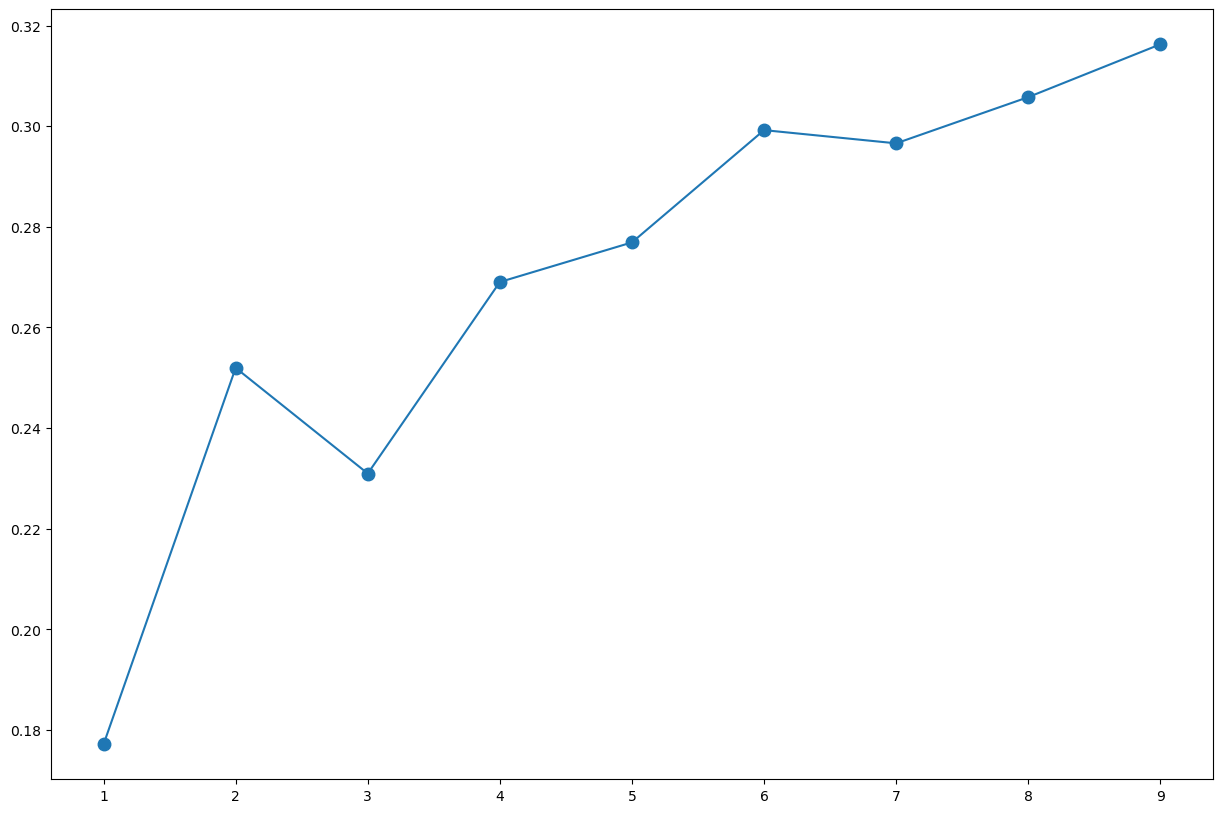

In [36]:
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier

error_rate = []

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test))

plt.figure(figsize=(15,10))
plt.plot(range(1,10),error_rate, marker='o', markersize=9)

In [37]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [38]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

0.5055539109717354

In [40]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

1.0709722812923723

# 'Goodness of fit' test

In [41]:
# Goodness of fit test for training data
from scipy.stats import chi2_contingency

expected_values = np.array([69, 8, 13, 4, 5])

observed_values = np.zeros(shape=(5))

observed_values[0] = (len(train_preds[train_preds == 0]) / len(X_train)) * 100
observed_values[1] = (len(train_preds[train_preds == 1]) / len(X_train)) * 100
observed_values[2] = (len(train_preds[train_preds == 2]) / len(X_train)) * 100
observed_values[3] = (len(train_preds[train_preds == 3]) / len(X_train)) * 100
observed_values[4] = (len(train_preds[train_preds == 4]) / len(X_train)) * 100

chi2_stat, p_value, dof, expected = chi2_contingency([observed_values, expected_values])

# Print results
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 0.34759777479037085
P-value: 0.9865379488201709
Degrees of freedom: 4
Expected frequencies:
[[71.53639419  7.53636778 12.47565026  3.64437166  4.80721611]
 [70.82103025  7.4610041  12.35089376  3.60792794  4.75914395]]


In [42]:
# Goodness of fit test for test data
observed_values = np.zeros(shape=(5))

observed_values[0] = (len(test_preds[test_preds == 0]) / len(X_test)) * 100
observed_values[1] = (len(test_preds[test_preds == 1]) / len(X_test)) * 100
observed_values[2] = (len(test_preds[test_preds == 2]) / len(X_test)) * 100
observed_values[3] = (len(test_preds[test_preds == 3]) / len(X_test)) * 100
observed_values[4] = (len(test_preds[test_preds == 4]) / len(X_test)) * 100

chi2_stat, p_value, dof, expected = chi2_contingency([observed_values, expected_values])

# Print results
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic: 4.738717801410996
P-value: 0.3151721089907731
Degrees of freedom: 4
Expected frequencies:
[[76.21968108  6.32822907 10.29161556  2.93330168  4.22717261]
 [75.45748427  6.26494678 10.1886994   2.90396866  4.18490088]]


# Confusion matrix

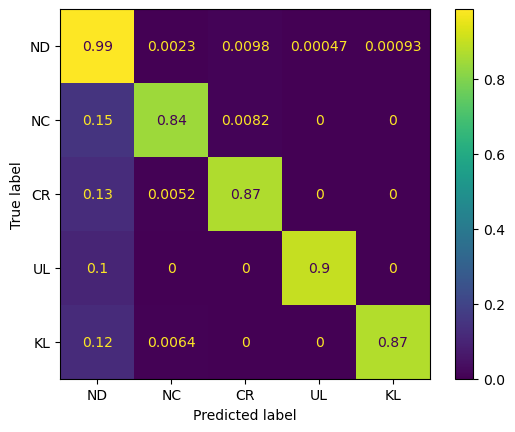

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_train, train_preds,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ND','NC','CR','UL','KL'])
disp.plot()
plt.show()

# Get ROC curve from TPR and FPR

Text(0.5, 1.0, 'ROC curve (training set)')

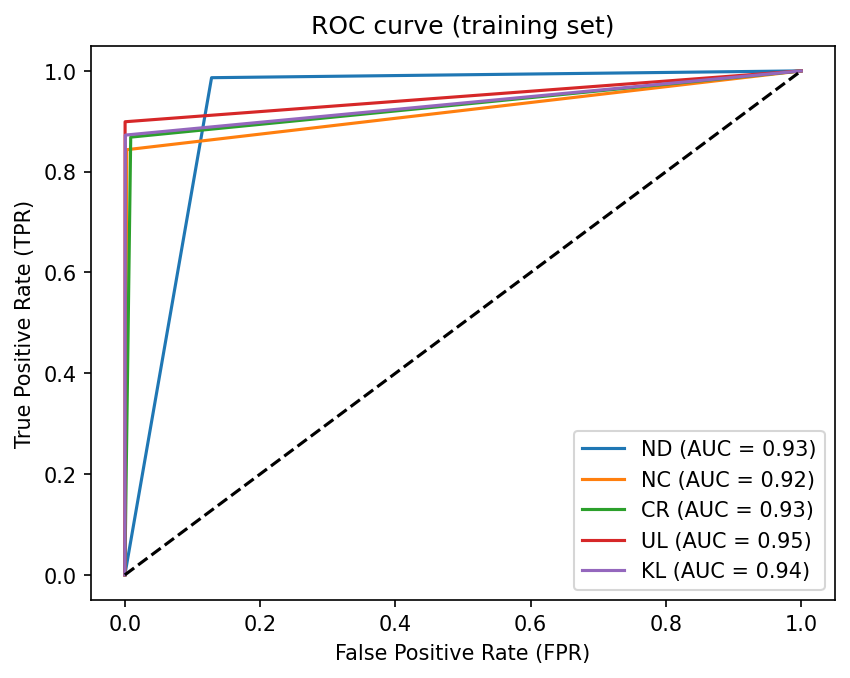

In [44]:
from sklearn.metrics import roc_curve, auc

nd_fpr, nd_tpr, nd_thresholds = roc_curve(y_train==0,train_preds==0)
nd_auc = auc(nd_fpr, nd_tpr)
nc_fpr, nc_tpr, nc_thresholds = roc_curve(y_train==1,train_preds==1)
nc_auc = auc(nc_fpr, nc_tpr)
cr_fpr, cr_tpr, cr_thresholds = roc_curve(y_train==2,train_preds==2)
cr_auc = auc(cr_fpr, cr_tpr)
ul_fpr, ul_tpr, ul_thresholds = roc_curve(y_train==3,train_preds==3)
ul_auc = auc(ul_fpr, ul_tpr)
kl_fpr, kl_tpr, kl_thresholds = roc_curve(y_train==4,train_preds==4)
kl_auc = auc(kl_fpr, kl_tpr)

plt.figure(dpi=150)
plt.plot(nd_fpr,nd_tpr,label='ND (AUC = {:.2f})'.format(nd_auc))
plt.plot(nc_fpr,nc_tpr,label='NC (AUC = {:.2f})'.format(nc_auc))
plt.plot(cr_fpr,cr_tpr,label='CR (AUC = {:.2f})'.format(cr_auc))
plt.plot(ul_fpr,ul_tpr,label='UL (AUC = {:.2f})'.format(ul_auc))
plt.plot(kl_fpr,kl_tpr,label='KL (AUC = {:.2f})'.format(kl_auc))
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.title('ROC curve (training set)')

# Calculate Brier Skill Score for each disturbance type

In [76]:
# Get probabilities for a single disturbance type
y_probs_knn = knn_model.predict_proba(X_train)

In [77]:
y_probs_knn = y_probs_knn[:,0] # Change 1-5 based on disturbance type

In [78]:
# Create binary array for occurrences
y_binary = np.zeros(shape=(len(X_train)))

true = np.where(y_train == 0)
y_binary[true] = 1
y_true = y_binary

In [79]:
# Create an array of probabilites from the null model
y_probs_reference = np.zeros(shape=(len(X_train)))

nd = 0.69
nc = 0.08
cr = 0.13
kl = 0.05
ul = 0.04

y_probs_reference[:] = nd # This is just the climatological freq of a disturbance

In [80]:
from sklearn.metrics import brier_score_loss

# Calculate Brier scores
bs_knn = brier_score_loss(y_true, y_probs_knn)
bs_reference = brier_score_loss(y_true, y_probs_reference)

# Calculate Brier Skill Score
bss = 1 - (bs_knn / bs_reference)
bss

0.748092078169484

In [81]:
observed = y_true
predicted_probs = np.round(y_probs_knn,2)
ref_probs = np.round(y_probs_reference,2)

# Number of bootstrap samples
n_bootstrap_samples = 1000

# Function to calculate Brier Skill Score
def calculate_bss(observed, predicted_probs,ref_probs):
    bs_reference = brier_score_loss(observed, ref_probs)
    bs_model = brier_score_loss(observed, predicted_probs)
    bss = 1 - (bs_model / bs_reference)
    return bss

# Bootstrap resampling
bss_values = []
for _ in range(n_bootstrap_samples):
    indices = np.random.choice(len(observed), len(observed), replace=True)
    bootstrap_observed = observed[indices]
    bootstrap_predicted_probs = predicted_probs[indices]
    bootstrap_ref_probs = ref_probs[indices]
    bss = calculate_bss(bootstrap_observed, bootstrap_predicted_probs,bootstrap_ref_probs)
    bss_values.append(bss)

# Calculate confidence interval
confidence_interval = np.percentile(bss_values, [2.5, 97.5])
print(f"Bootstrap BSS Confidence Interval: {confidence_interval}")

Bootstrap BSS Confidence Interval: [0.73324803 0.7673294 ]


# Calculate log score for train/test set

In [51]:
# Create a binary array for the 'true' labels
y_train_binary = np.zeros(shape=(len(y_train),5))
y_test_binary = np.zeros(shape=(len(y_test),5))

In [52]:
for i in range(0,len(y_train)):
    label = y_train[i]
    if label == 0.0:
        y_train_binary[i,0] = 1
    elif label == 1.0:
        y_train_binary[i,1] = 1
    elif label == 2.0:
        y_train_binary[i,2] = 1
    elif label == 3.0:
        y_train_binary[i,3] = 1
    elif label == 4.0:
        y_train_binary[i,4] = 1
    elif label == 5.0:
        y_train_binary[i,5] = 1

for i in range(0,len(y_test)):
    label = y_test[i]
    if label == 0.0:
        y_test_binary[i,0] = 1
    elif label == 1.0:
        y_test_binary[i,1] = 1
    elif label == 2.0:
        y_test_binary[i,2] = 1
    elif label == 3.0:
        y_test_binary[i,3] = 1
    elif label == 4.0:
        y_test_binary[i,4] = 1
    elif label == 5.0:
        y_test_binary[i,5] = 1

In [53]:
# True labels (ground truth)
y_true = y_train_binary

# Predicted probabilities (example values)
y_pred_prob = knn_model.predict_proba(X_train)
y_pred_prob = np.round(y_pred_prob,1) # Round probs

In [54]:
# Avoid log(0) by adding a small epsilon
epsilon = 1e-15

# Clip predicted probabilities to avoid log(0) or log(1)
y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)

# Calculate logarithmic score
log_score = -np.mean(np.sum(y_true * np.log(y_pred_prob), axis=1))

print(f"Logarithmic Score (training): {log_score:.4f}")

Logarithmic Score (training): 0.1809


In [55]:
# True labels (ground truth)
y_true = y_test_binary

# Predicted probabilities (example values)
y_pred_prob = knn_model.predict_proba(X_test)
y_pred_prob = np.round(y_pred_prob,1) # Round probs

In [56]:
# Avoid log(0) by adding a small epsilon
epsilon = 1e-15

# Clip predicted probabilities to avoid log(0) or log(1)
y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)

# Calculate logarithmic score
log_score = -np.mean(np.sum(y_true * np.log(y_pred_prob), axis=1))

print(f"Logarithmic Score (test): {log_score:.4f}")

Logarithmic Score (test): 1.4969


# Calculate more skill metrics

In [57]:
skill_metrics = np.zeros(shape=(5,4))

from sklearn.metrics import precision_score
skill_metrics[0,0] = precision_score(y_train==0, train_preds==0)
skill_metrics[1,0] = precision_score(y_train==1, train_preds==1)
skill_metrics[2,0] = precision_score(y_train==2, train_preds==2)
skill_metrics[3,0] = precision_score(y_train==3, train_preds==3)
skill_metrics[4,0] = precision_score(y_train==4, train_preds==4)

from sklearn.metrics import accuracy_score
skill_metrics[0,1] = accuracy_score(y_train==0, train_preds==0)
skill_metrics[1,1] = accuracy_score(y_train==1, train_preds==1)
skill_metrics[2,1] = accuracy_score(y_train==2, train_preds==2)
skill_metrics[3,1] = accuracy_score(y_train==3, train_preds==3)
skill_metrics[4,1] = accuracy_score(y_train==4, train_preds==4)

from sklearn.metrics import recall_score
skill_metrics[0,2] = recall_score(y_train==0, train_preds==0)
skill_metrics[1,2] = recall_score(y_train==1, train_preds==1)
skill_metrics[2,2] = recall_score(y_train==2, train_preds==2)
skill_metrics[3,2] = recall_score(y_train==3, train_preds==3)
skill_metrics[4,2] = recall_score(y_train==4, train_preds==4)

from sklearn.metrics import f1_score
skill_metrics[0,3] = f1_score(y_train==0, train_preds==0)
skill_metrics[1,3] = f1_score(y_train==1, train_preds==1)
skill_metrics[2,3] = f1_score(y_train==2, train_preds==2)
skill_metrics[3,3] = f1_score(y_train==3, train_preds==3)
skill_metrics[4,3] = f1_score(y_train==4, train_preds==4)

skill_metrics

array([[0.94849978, 0.95269382, 0.98649278, 0.96712329],
       [0.96244131, 0.9848883 , 0.8436214 , 0.89912281],
       [0.93611111, 0.97568988, 0.8685567 , 0.90106952],
       [0.98989899, 0.99605782, 0.89908257, 0.94230769],
       [0.98561151, 0.99277267, 0.87261146, 0.92567568]])

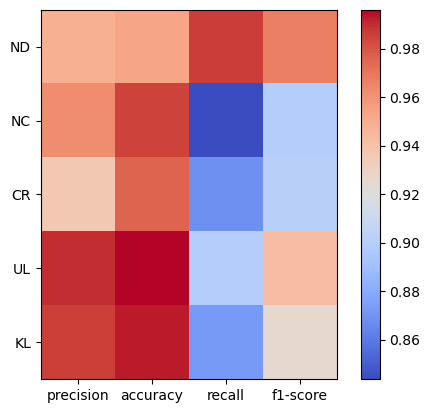

In [58]:
plt.figure(dpi=100)
plt.imshow(skill_metrics, cmap='coolwarm', interpolation='nearest')
plt.xticks(ticks = np.arange(4),labels=['precision','accuracy','recall','f1-score'])
plt.yticks(ticks = np.arange(5),labels=['ND','NC','CR','UL','KL'])
plt.colorbar()

# Display the heatmap
plt.show()

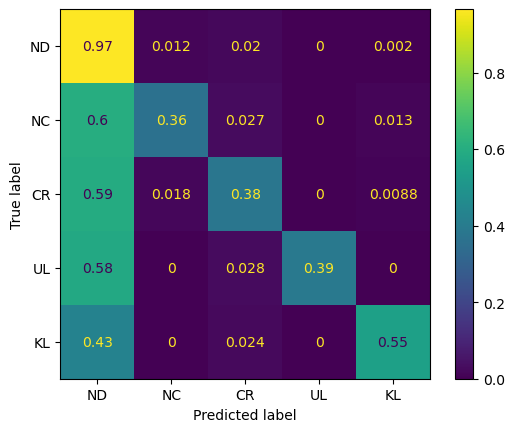

In [59]:
cm=confusion_matrix(y_test, test_preds,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ND','NC','CR','UL','KL'])
disp.plot()
plt.show()

Text(0.5, 1.0, 'ROC curve (test set)')

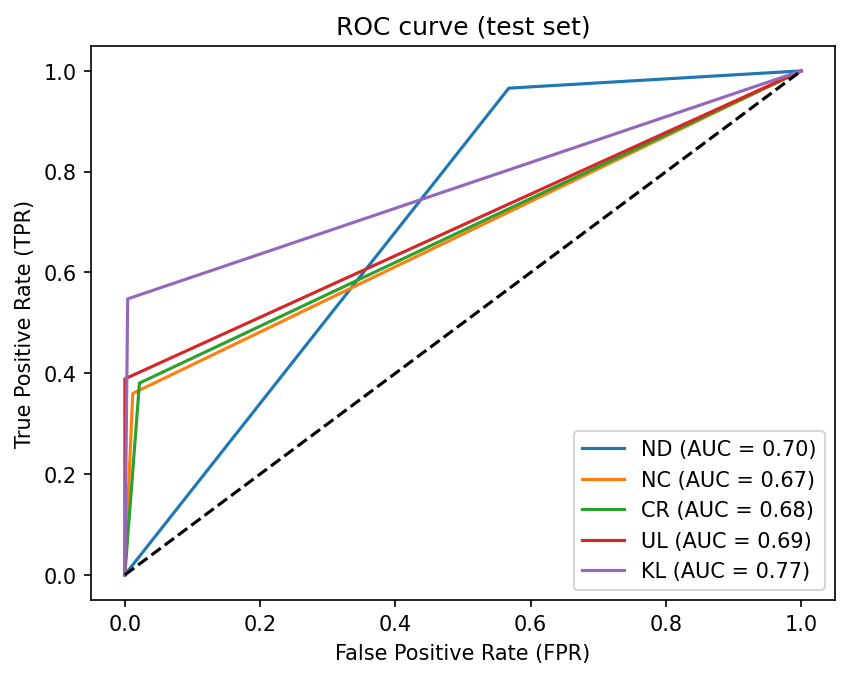

In [60]:
nd_fpr, nd_tpr, nd_thresholds = roc_curve(y_test==0,test_preds==0)
nd_auc = auc(nd_fpr, nd_tpr)
nc_fpr, nc_tpr, nc_thresholds = roc_curve(y_test==1,test_preds==1)
nc_auc = auc(nc_fpr, nc_tpr)
cr_fpr, cr_tpr, cr_thresholds = roc_curve(y_test==2,test_preds==2)
cr_auc = auc(cr_fpr, cr_tpr)
ul_fpr, ul_tpr, ul_thresholds = roc_curve(y_test==3,test_preds==3)
ul_auc = auc(ul_fpr, ul_tpr)
kl_fpr, kl_tpr, kl_thresholds = roc_curve(y_test==4,test_preds==4)
kl_auc = auc(kl_fpr, kl_tpr)

plt.figure(dpi=150)
plt.plot(nd_fpr,nd_tpr,label='ND (AUC = {:.2f})'.format(nd_auc))
plt.plot(nc_fpr,nc_tpr,label='NC (AUC = {:.2f})'.format(nc_auc))
plt.plot(cr_fpr,cr_tpr,label='CR (AUC = {:.2f})'.format(cr_auc))
plt.plot(ul_fpr,ul_tpr,label='UL (AUC = {:.2f})'.format(ul_auc))
plt.plot(kl_fpr,kl_tpr,label='KL (AUC = {:.2f})'.format(kl_auc))
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.title('ROC curve (test set)')

In [61]:
skill_metrics = np.zeros(shape=(5,4))

skill_metrics[0,0] = precision_score(y_test==0, test_preds==0)
skill_metrics[1,0] = precision_score(y_test==1, test_preds==1)
skill_metrics[2,0] = precision_score(y_test==2, test_preds==2)
skill_metrics[3,0] = precision_score(y_test==3, test_preds==3)
skill_metrics[4,0] = precision_score(y_test==4, test_preds==4)

skill_metrics[0,1] = accuracy_score(y_test==0, test_preds==0)
skill_metrics[1,1] = accuracy_score(y_test==1, test_preds==1)
skill_metrics[2,1] = accuracy_score(y_test==2, test_preds==2)
skill_metrics[3,1] = accuracy_score(y_test==3, test_preds==3)
skill_metrics[4,1] = accuracy_score(y_test==4, test_preds==4)

skill_metrics[0,2] = recall_score(y_test==0, test_preds==0)
skill_metrics[1,2] = recall_score(y_test==1, test_preds==1)
skill_metrics[2,2] = recall_score(y_test==2, test_preds==2)
skill_metrics[3,2] = recall_score(y_test==3, test_preds==3)
skill_metrics[4,2] = recall_score(y_test==4, test_preds==4)

skill_metrics[0,3] = f1_score(y_test==0, test_preds==0)
skill_metrics[1,3] = f1_score(y_test==1, test_preds==1)
skill_metrics[2,3] = f1_score(y_test==2, test_preds==2)
skill_metrics[3,3] = f1_score(y_test==3, test_preds==3)
skill_metrics[4,3] = f1_score(y_test==4, test_preds==4)

skill_metrics

array([[0.76031746, 0.77952756, 0.96572581, 0.85079929],
       [0.77142857, 0.92650919, 0.36      , 0.49090909],
       [0.75438596, 0.88976378, 0.38053097, 0.50588235],
       [1.        , 0.97112861, 0.38888889, 0.56      ],
       [0.88461538, 0.97112861, 0.54761905, 0.67647059]])

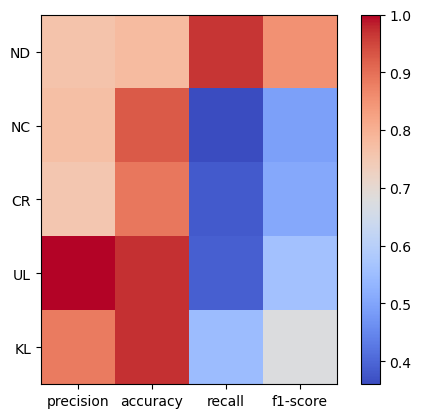

In [62]:
plt.figure(dpi=100)
plt.imshow(skill_metrics, cmap='coolwarm', interpolation='nearest')
plt.xticks(ticks = np.arange(4),labels=['precision','accuracy','recall','f1-score'])
plt.yticks(ticks = np.arange(5),labels=['ND','NC','CR','UL','KL'])
plt.colorbar()

# Display the heatmap
plt.show()

In [63]:
# Get probabilities for a single disturbance type
y_probs_knn = knn_model.predict_proba(X_test)[:,4]

In [64]:
# Create binary array for occurrences
y_binary = np.zeros(shape=(len(X_test)))

true = np.where(y_test == 4)
y_binary[true] = 1
y_true = y_binary

In [65]:
# Create an array of probabilites from the null model
y_probs_reference = np.zeros(shape=(len(X_test)))

nd = 0.69
nc = 0.08
cr = 0.13
kl = 0.05
ul = 0.04

y_probs_reference[:] = kl # This is just the climatological freq of a disturbance

In [66]:
from sklearn.metrics import brier_score_loss

# Calculate Brier scores
bs_knn = brier_score_loss(y_true, y_probs_knn)
bs_reference = brier_score_loss(y_true, y_probs_reference)

# Calculate Brier Skill Score
bss = 1 - (bs_knn / bs_reference)
bss

0.5690439211406344

# How well does the knn model represent the 'truth'?

In [67]:
preds = knn_model.predict(X_train)

In [68]:
pred_ND = np.where(preds == 0)
pred_NC = np.where(preds == 1)
pred_CR = np.where(preds == 2)
pred_UL = np.where(preds == 3)
pred_KL = np.where(preds == 4)

In [69]:
ND_pattern = np.mean(u_train[pred_ND],axis=0)
NC_pattern = np.mean(u_train[pred_NC],axis=0)
CR_pattern = np.mean(u_train[pred_CR],axis=0)
UL_pattern = np.mean(u_train[pred_UL],axis=0)
KL_pattern = np.mean(u_train[pred_KL],axis=0)

In [70]:
ND_pred = np.reshape(ND_pattern, (401*681), order = 'F')
NC_pred = np.reshape(NC_pattern, (401*681), order = 'F')
CR_pred = np.reshape(CR_pattern, (401*681), order = 'F')
UL_pred = np.reshape(UL_pattern, (401*681), order = 'F')
KL_pred = np.reshape(KL_pattern, (401*681), order = 'F')

In [71]:
import scipy

print('ND: ',scipy.stats.pearsonr(ND_pred, ND_truth).statistic)
print('NC: ',scipy.stats.pearsonr(NC_pred, NC_truth).statistic)
print('CR: ',scipy.stats.pearsonr(CR_pred, CR_truth).statistic)
print('UL: ',scipy.stats.pearsonr(UL_pred, UL_truth).statistic)
print('KL: ',scipy.stats.pearsonr(KL_pred, KL_truth).statistic)

ND:  0.959786846290852
NC:  0.9682873811437834
CR:  0.9712866350904812
UL:  0.9676787664968587
KL:  0.98682945612947


# Get skill metrics for train/test sets

In [72]:
from sklearn.metrics import precision_score
print(precision_score(y_train, train_preds, average='weighted'))
print(precision_score(y_test, test_preds, average='weighted'))

0.9514301468126054
0.778706119899655


In [73]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, train_preds))
print(accuracy_score(y_test, test_preds))

0.9510512483574245
0.7690288713910761


In [74]:
from sklearn.metrics import recall_score
print(recall_score(y_train, train_preds, average='weighted'))
print(recall_score(y_test, test_preds, average='weighted'))

0.9510512483574245
0.7690288713910761


In [75]:
from sklearn.metrics import f1_score
print(f1_score(y_train, train_preds, average='weighted'))
print(f1_score(y_test, test_preds, average='weighted'))

0.9502490583245901
0.7408807086726357
